In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import re
from typing import Iterable, Optional, Dict
import seaborn as sns

In [2]:
def plot_gep_comparisons(df1, df2, gep_pairs, figsize=(15, 10), ncols=3):
    """
    Create multiple scatterplots comparing GEPs from two dataframes.
    
    Parameters:
    -----------
    df1 : pandas.DataFrame
        First dataframe where rows are GEPs and columns are genes
    df2 : pandas.DataFrame
        Second dataframe where rows are GEPs and columns are genes
    gep_pairs : list of tuples
        List of (df1_row_idx, df2_row_idx) pairs to compare
        Example: [(0, 0), (1, 1), (0, 1), (2, 3)]
    figsize : tuple
        Figure size (width, height)
    ncols : int
        Number of columns in the subplot grid
    
    Returns:
    --------
    fig, axes : matplotlib figure and axes objects
    """
    n_plots = len(gep_pairs)
    nrows = int(np.ceil(n_plots / ncols))
    
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten() if n_plots > 1 else [axes]
    
    for idx, (gep1_idx, gep2_idx) in enumerate(gep_pairs):
        ax = axes[idx]
        
        # Extract data
        y = df1.iloc[gep1_idx]  # y-axis values
        x = df2.iloc[gep2_idx]  # x-axis values
        
        # Create scatterplot
        ax.scatter(x, y, alpha=0.6, s=30)
        
        # Add diagonal reference line
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 
                'r--', alpha=0.5, linewidth=1, label='y=x')
        
        # Calculate correlation
        correlation = np.corrcoef(x, y)[0, 1]
        
        # Labels and title
        ax.set_xlabel(f"GEP {gep2_idx + 1}", fontsize=10)
        ax.set_ylabel(f"GEP {gep1_idx + 1}", fontsize=10)
        ax.set_title(f"GEP {gep1_idx + 1} vs GEP {gep2_idx + 1}\n(r = {correlation:.3f})", fontsize=11)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    return fig, axes

## S1, k=8 vs. k=9

In [3]:
s1_k8 = pd.read_csv('all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs/anal_pc5_c21_S1.filtered.gene_spectra_score.k_8.dt_0_01.txt', sep='\t', index_col=0)
s1_k8.head()

,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AARD,AASS,AATK,ABCA1,...,ZNF83,ZNF831,ZNRF1,ZSCAN18,ZSCAN2,ZSCAN26,ZSCAN31,ZSCAN32,ZSWIM9,ZWINT
1,-0.000343,-0.000041,5.677135e-07,0.000667,0.000121,0.000170,-0.000024,0.000315,-0.000123,0.000016,...,0.000344,-0.000139,0.000078,0.000057,-0.000039,0.000068,0.000054,0.000040,0.000111,0.000799
2,-0.000340,-0.000099,1.549244e-07,-0.000336,0.000047,-0.000082,-0.000026,-0.000149,-0.000076,-0.000208,...,0.000091,0.000584,0.000265,0.000153,0.000187,0.000101,-0.000070,0.000139,0.000147,-0.000268
3,-0.000297,-0.000119,1.186658e-05,-0.000345,-0.000091,0.000147,-0.000030,-0.000186,0.000353,-0.000218,...,-0.000304,-0.000138,-0.000024,-0.000155,-0.000058,-0.000102,0.000007,-0.000055,-0.000088,-0.000194
4,-0.000589,-0.000140,-2.302119e-05,-0.000533,-0.000187,-0.000264,-0.000027,-0.000329,-0.000211,-0.000486,...,-0.000496,-0.000343,-0.000543,-0.000269,-0.000101,-0.000179,-0.000019,-0.000162,-0.000263,-0.000490
5,0.001948,-0.000068,3.161054e-06,0.000043,-0.000027,-0.000084,0.000083,0.000186,0.000003,0.000371,...,0.000031,-0.000082,-0.000103,0.000065,-0.000019,0.000048,0.000005,-0.000042,-0.000023,-0.000266


In [4]:
s1_k8 = s1_k8.dropna(axis='columns', how='any')
s1_k8.head(7)

,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AARD,AASS,AATK,ABCA1,...,ZNF83,ZNF831,ZNRF1,ZSCAN18,ZSCAN2,ZSCAN26,ZSCAN31,ZSCAN32,ZSWIM9,ZWINT
1,-0.000343,-0.000041,5.677135e-07,0.000667,0.000121,0.000170,-0.000024,0.000315,-0.000123,0.000016,...,0.000344,-0.000139,0.000078,0.000057,-0.000039,0.000068,0.000054,0.000040,0.000111,0.000799
2,-0.000340,-0.000099,1.549244e-07,-0.000336,0.000047,-0.000082,-0.000026,-0.000149,-0.000076,-0.000208,...,0.000091,0.000584,0.000265,0.000153,0.000187,0.000101,-0.000070,0.000139,0.000147,-0.000268
3,-0.000297,-0.000119,1.186658e-05,-0.000345,-0.000091,0.000147,-0.000030,-0.000186,0.000353,-0.000218,...,-0.000304,-0.000138,-0.000024,-0.000155,-0.000058,-0.000102,0.000007,-0.000055,-0.000088,-0.000194
4,-0.000589,-0.000140,-2.302119e-05,-0.000533,-0.000187,-0.000264,-0.000027,-0.000329,-0.000211,-0.000486,...,-0.000496,-0.000343,-0.000543,-0.000269,-0.000101,-0.000179,-0.000019,-0.000162,-0.000263,-0.000490
5,0.001948,-0.000068,3.161054e-06,0.000043,-0.000027,-0.000084,0.000083,0.000186,0.000003,0.000371,...,0.000031,-0.000082,-0.000103,0.000065,-0.000019,0.000048,0.000005,-0.000042,-0.000023,-0.000266
6,0.000215,-0.000055,-8.204640e-06,-0.000155,0.000096,-0.000149,0.000018,-0.000137,0.000163,0.001243,...,-0.000165,-0.000149,-0.000147,-0.000088,-0.000053,0.000012,-0.000004,-0.000030,-0.000047,-0.000108
7,0.000453,-0.000040,4.212105e-05,0.000183,-0.000062,-0.000049,0.000088,0.000083,0.000047,-0.000073,...,0.000111,-0.000015,0.000044,0.000213,0.000043,-0.000003,0.000013,-0.000043,-0.000038,-0.000179


In [5]:
s1_k9 = pd.read_csv('all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs/anal_pc5_c21_S1.filtered.gene_spectra_score.k_9.dt_0_01.txt', sep='\t', index_col=0)
s1_k9.head()

,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AARD,AASS,AATK,ABCA1,...,ZNF83,ZNF831,ZNRF1,ZSCAN18,ZSCAN2,ZSCAN26,ZSCAN31,ZSCAN32,ZSWIM9,ZWINT
1,-0.000343,-0.000040,6.636012e-07,0.000670,0.000122,0.000171,-0.000024,0.000316,-0.000123,0.000016,...,0.000346,-0.000139,0.000079,0.000058,-0.000039,0.000068,0.000054,0.000040,0.000112,0.000801
2,-0.000349,-0.000102,-3.675140e-06,-0.000363,0.000037,-0.000091,-0.000024,-0.000163,-0.000079,-0.000219,...,0.000043,0.000657,0.000331,0.000114,0.000167,0.000076,-0.000064,0.000126,0.000121,-0.000305
3,-0.000296,-0.000119,1.210965e-05,-0.000344,-0.000091,0.000147,-0.000030,-0.000186,0.000354,-0.000218,...,-0.000302,-0.000141,-0.000026,-0.000153,-0.000057,-0.000101,0.000006,-0.000054,-0.000087,-0.000194
4,-0.000610,-0.000145,-2.966350e-05,-0.000582,-0.000198,-0.000278,-0.000025,-0.000341,-0.000210,-0.000504,...,-0.000559,-0.000239,-0.000444,-0.000334,-0.000136,-0.000212,-0.000007,-0.000184,-0.000310,-0.000543
5,0.001955,-0.000067,3.580003e-06,0.000044,-0.000026,-0.000084,0.000084,0.000187,0.000003,0.000373,...,0.000033,-0.000085,-0.000105,0.000067,-0.000018,0.000049,0.000005,-0.000041,-0.000022,-0.000265


In [6]:
s1_k9 = s1_k9.dropna(axis='columns', how='any')
s1_k9.head(7)

,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AARD,AASS,AATK,ABCA1,...,ZNF83,ZNF831,ZNRF1,ZSCAN18,ZSCAN2,ZSCAN26,ZSCAN31,ZSCAN32,ZSWIM9,ZWINT
1,-0.000343,-0.000040,6.636012e-07,0.000670,0.000122,0.000171,-0.000024,0.000316,-0.000123,0.000016,...,0.000346,-0.000139,0.000079,0.000058,-0.000039,0.000068,5.444932e-05,0.000040,0.000112,0.000801
2,-0.000349,-0.000102,-3.675140e-06,-0.000363,0.000037,-0.000091,-0.000024,-0.000163,-0.000079,-0.000219,...,0.000043,0.000657,0.000331,0.000114,0.000167,0.000076,-6.393708e-05,0.000126,0.000121,-0.000305
3,-0.000296,-0.000119,1.210965e-05,-0.000344,-0.000091,0.000147,-0.000030,-0.000186,0.000354,-0.000218,...,-0.000302,-0.000141,-0.000026,-0.000153,-0.000057,-0.000101,6.464571e-06,-0.000054,-0.000087,-0.000194
4,-0.000610,-0.000145,-2.966350e-05,-0.000582,-0.000198,-0.000278,-0.000025,-0.000341,-0.000210,-0.000504,...,-0.000559,-0.000239,-0.000444,-0.000334,-0.000136,-0.000212,-6.917636e-06,-0.000184,-0.000310,-0.000543
5,0.001955,-0.000067,3.580003e-06,0.000044,-0.000026,-0.000084,0.000084,0.000187,0.000003,0.000373,...,0.000033,-0.000085,-0.000105,0.000067,-0.000018,0.000049,5.039700e-06,-0.000041,-0.000022,-0.000265
6,-0.000318,-0.000093,7.803059e-06,-0.000249,0.000021,-0.000105,-0.000029,-0.000147,-0.000085,-0.000108,...,0.000079,-0.000045,-0.000272,0.000163,0.000159,0.000103,-7.515000e-05,0.000085,0.000118,-0.000162
7,0.000214,-0.000056,-1.048617e-05,-0.000168,0.000093,-0.000153,0.000019,-0.000140,0.000163,0.001249,...,-0.000180,-0.000122,-0.000123,-0.000100,-0.000061,0.000004,-3.563241e-07,-0.000034,-0.000057,-0.000120


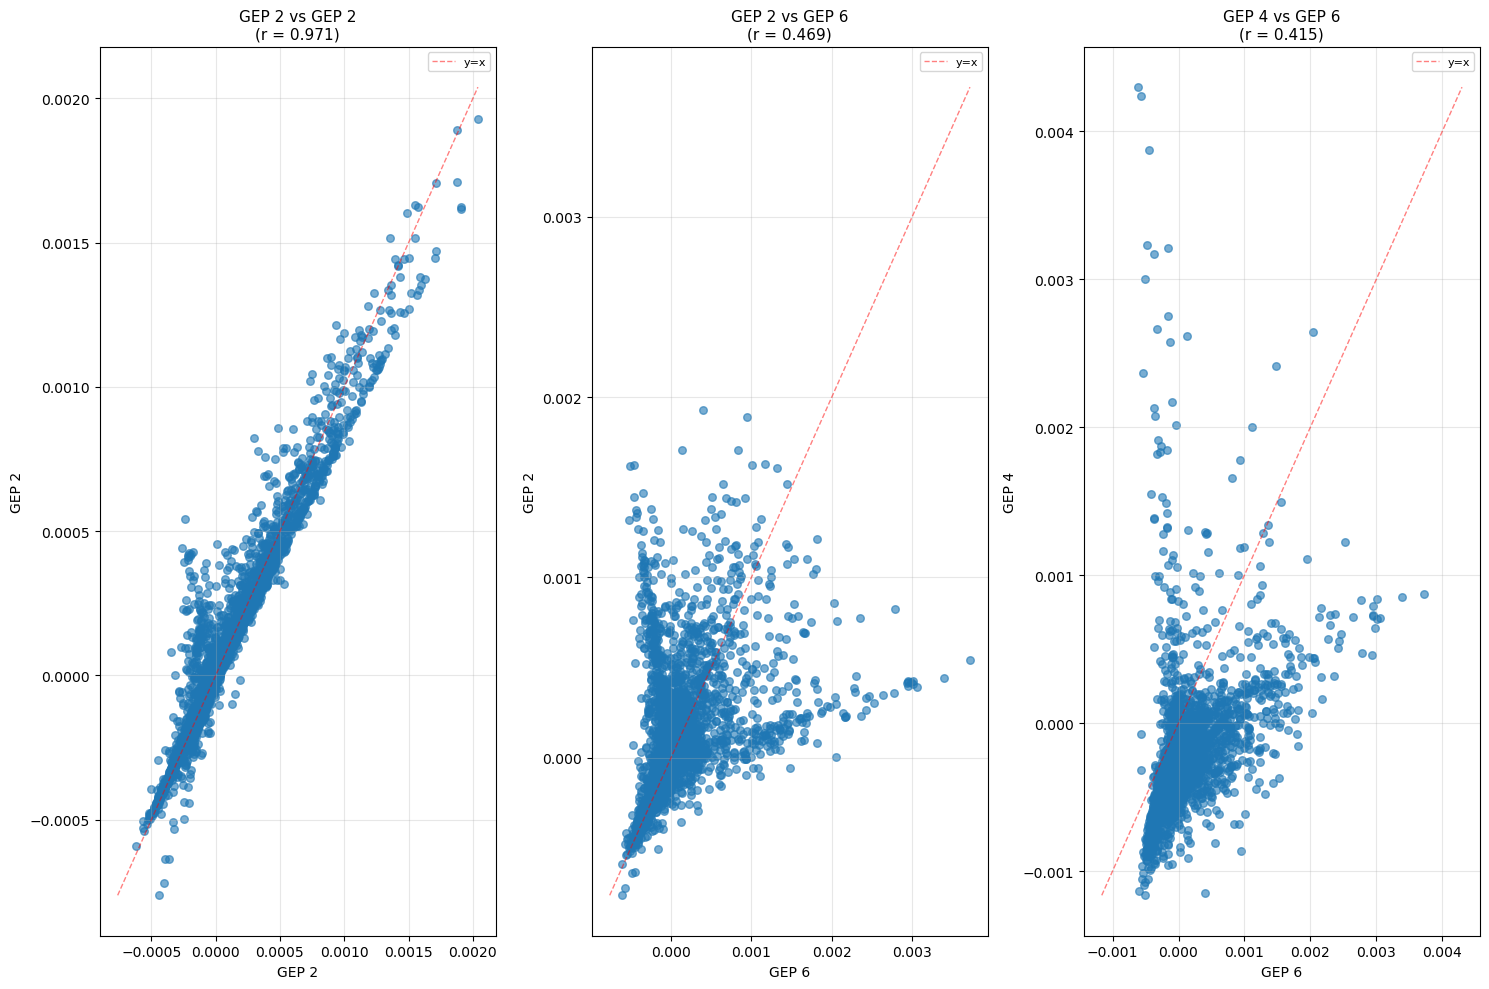

In [7]:
gep_comparisons = [
    (1, 1),  # GEP 2 vs GEP 2
    (1, 5),
    (3, 5)
]

fig, axes = plot_gep_comparisons(s1_k8, s1_k9, gep_comparisons, figsize=(15, 10), ncols=3)
plt.show()

### Heatmap -- sorting all 5000 genes by the primary i.e. 'best' GEP

sort columns i.e. genes with the following order:
- all genes whose best row is GEP 1
- then all genes whose best row is GEP 2
- then all genes whose best row is GEP 3
- and so on

In [8]:
def plot_heatmaps_per_k(
    output_dir: str,
    name: str,
    k_range: Optional[Iterable[int]] = None,
    density_threshold: float = 0.01,
    cmap: str = "Reds",
    sort_columns: bool = True,
    save_dir: Optional[str] = None,     
) -> Dict[int, plt.Figure]:
    """
    Create separate heatmaps for each K using pre–z-scored spectra matrices.

    Sorting logic (when sort_columns=True):
      - For each gene (column), find the row (GEP) with the max absolute loading.
      - Sort columns by (primary_GEP, then descending strength).
        This produces:
          all genes whose best row is 0 (strongest → weakest),
          then all genes whose best row is 1,
          then all genes whose best row is 2, ...
    """

    dt_str = str(density_threshold).replace(".", "_")
    spectra_dict: Dict[int, pd.DataFrame] = {}

    # ---------------------------------------
    # Prepare saving directory
    # ---------------------------------------
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    # ---------------------------
    # 1) Load spectra files
    # ---------------------------
    if k_range is None:
        search_path = os.path.join(
            output_dir,
            f"{name}.gene_spectra_score.k_*.dt_{dt_str}.txt"
        )
        files = glob.glob(search_path)

        if not files:
            raise FileNotFoundError(f"No files match: {search_path}")

        for f in files:
            m = re.search(r"\.k_(\d+)\.", os.path.basename(f))
            if not m:
                continue
            k = int(m.group(1))
            df = pd.read_csv(f, sep="\t", index_col=0)
            spectra_dict[k] = df
            print(f"Loaded K={k}: {df.shape}")
            print(f"K={k} | min={df.min().min():.4f} max={df.max().max():.4f}")
    else:
        for k in k_range:
            path = os.path.join(
                output_dir,
                f"{name}.gene_spectra_score.k_{k}.dt_{dt_str}.txt"
            )
            if not os.path.exists(path):
                raise FileNotFoundError(path)
            df = pd.read_csv(path, sep="\t", index_col=0)
            spectra_dict[k] = df
            print(f"Loaded K={k}: {df.shape}")
            print(f"K={k} | min={df.min().min():.4f} max={df.max().max():.4f}")

    # ---------------------------
    # 2) Create heatmaps
    # ---------------------------
    figs: Dict[int, plt.Figure] = {}

    for k, df in sorted(spectra_dict.items()):

        # --------- column sorting: group by primary GEP, then strength ----------
        if sort_columns:
            vals = df.values  # shape: (n_geps, n_genes)

            # primary GEP for each gene = row with max absolute value
            abs_vals = np.abs(vals)
            primary_gep = abs_vals.argmax(axis=0)   # length n_genes
            primary_strength = abs_vals.max(axis=0)

            # Sort by (primary_gep, -primary_strength)
            sort_idx = np.lexsort((
                -primary_strength,
                primary_gep,
            ))

            df = df.iloc[:, sort_idx]
        # else: no sorting

        # -------------------------------------------------------
        fig_width = 12
        fig_height = max(4, df.shape[0] * 0.4)

        fig, ax = plt.subplots(figsize=(fig_width, fig_height))
        local_vmin = df.min().min()
        local_vmax = df.max().max()

        sns.heatmap(
            df,
            cmap=cmap,
            vmin=local_vmin,
            vmax=local_vmax,
            xticklabels=False,
            yticklabels=True,
            ax=ax
        )

        ax.set_title(
            f"Gene Spectra for K={k}\n(all genes, columns sorted by primary GEP then strength)",
            fontsize=14
        )
        ax.set_xlabel("")   # remove x-axis label
        ax.set_ylabel("GEPs")
        ax.set_xticks([])   # No x tick labels
        ax.tick_params(axis="y", labelsize=8)

        figs[k] = fig

        # ------------------------------------
        # Save the figure if requested
        # ------------------------------------
        if save_dir is not None:
            out_path = os.path.join(save_dir, f"{name}_GEP{k}.png")
            fig.savefig(out_path, dpi=150, bbox_inches="tight")
            print(f"Saved: {out_path}")

    return figs


Loaded K=10: (10, 5000)
K=10 | min=-0.0014 max=0.0064
Loaded K=11: (11, 5000)
K=11 | min=-0.0014 max=0.0061
Loaded K=12: (12, 5000)
K=12 | min=-0.0014 max=0.0066
Loaded K=13: (13, 5000)
K=13 | min=-0.0014 max=0.0068
Loaded K=14: (14, 5000)
K=14 | min=-0.0014 max=0.0109
Loaded K=15: (15, 5000)
K=15 | min=-0.0014 max=0.0110
Loaded K=16: (16, 5000)
K=16 | min=-0.0014 max=0.0116
Loaded K=17: (17, 5000)
K=17 | min=-0.0026 max=0.0118
Loaded K=18: (18, 5000)
K=18 | min=-0.0069 max=0.0268
Loaded K=19: (19, 5000)
K=19 | min=-0.0038 max=0.0147
Loaded K=20: (20, 5000)
K=20 | min=-0.0022 max=0.0144
Loaded K=21: (21, 5000)
K=21 | min=-0.0077 max=0.0182
Loaded K=5: (5, 5000)
K=5 | min=-0.0007 max=0.0030
Loaded K=6: (6, 5000)
K=6 | min=-0.0007 max=0.0063
Loaded K=7: (7, 5000)
K=7 | min=-0.0012 max=0.0061
Loaded K=8: (8, 5000)
K=8 | min=-0.0012 max=0.0061
Loaded K=9: (9, 5000)
K=9 | min=-0.0012 max=0.0061
Saved: sorted_heatmaps\anal_pc5_c21_S1.filtered_GEP5.png
Saved: sorted_heatmaps\anal_pc5_c21_S1.f

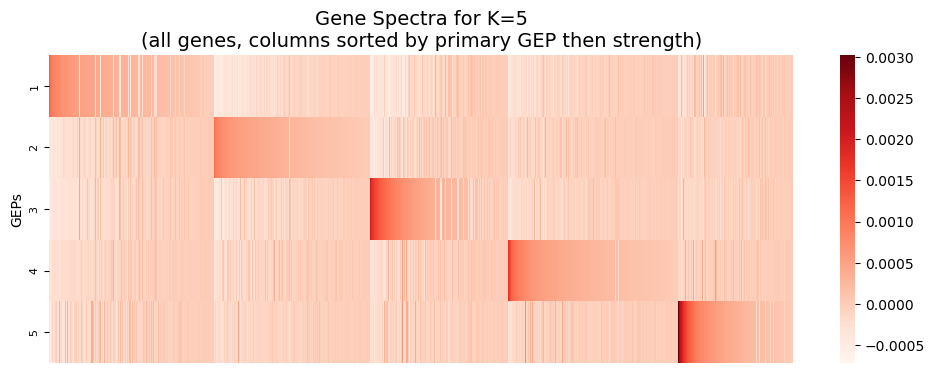

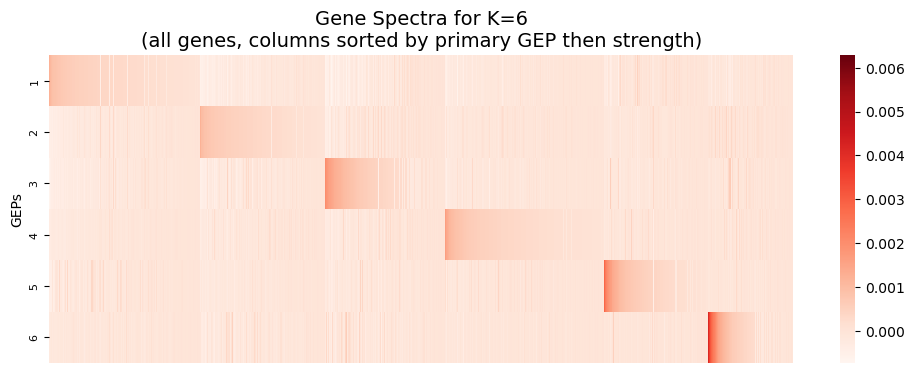

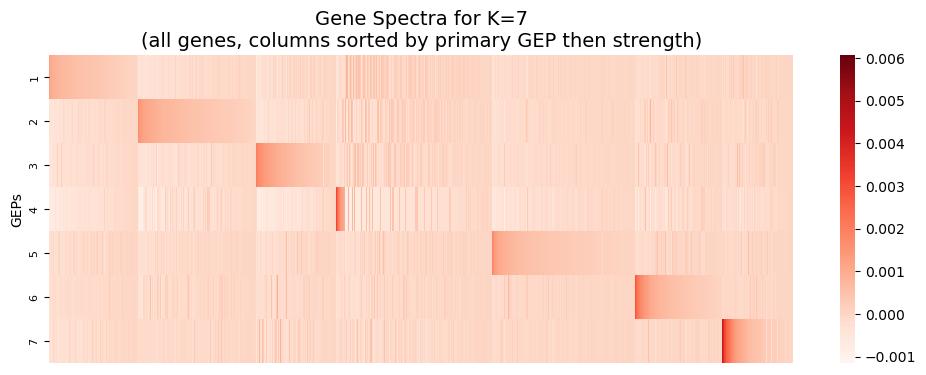

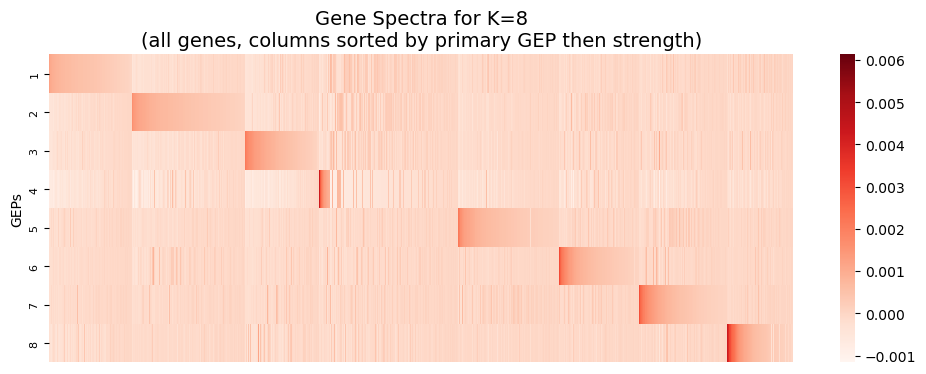

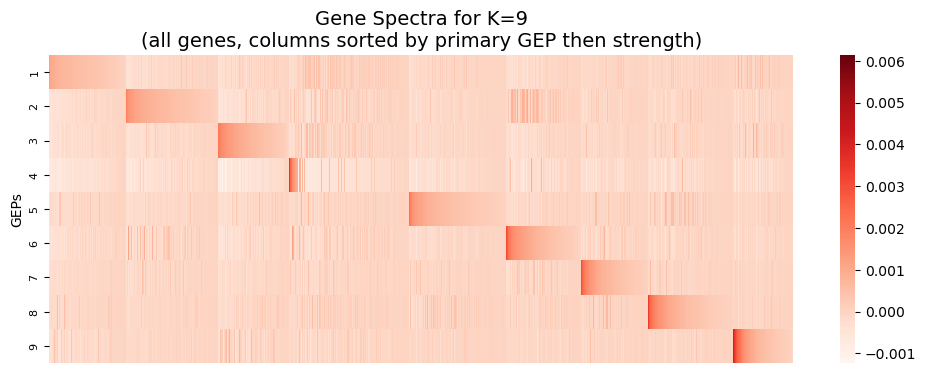

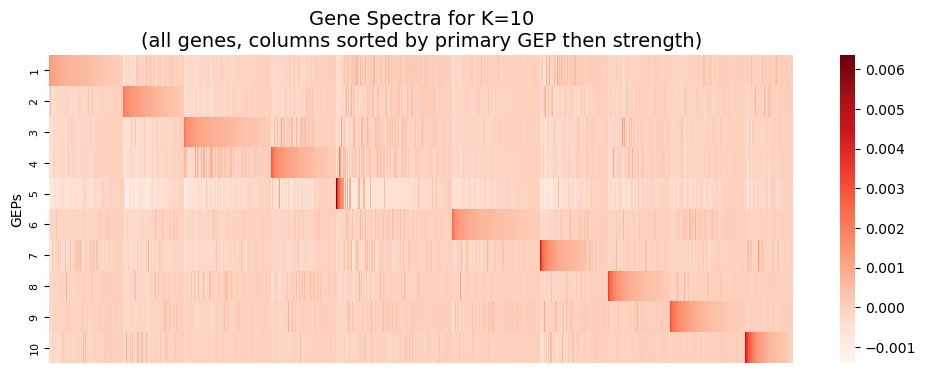

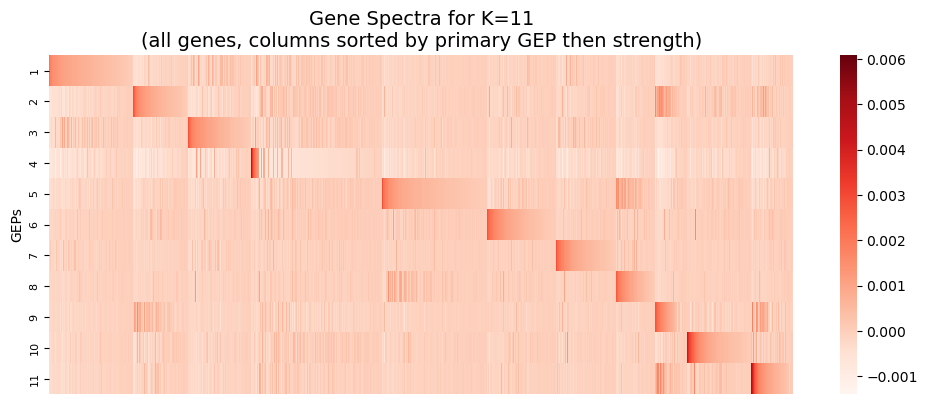

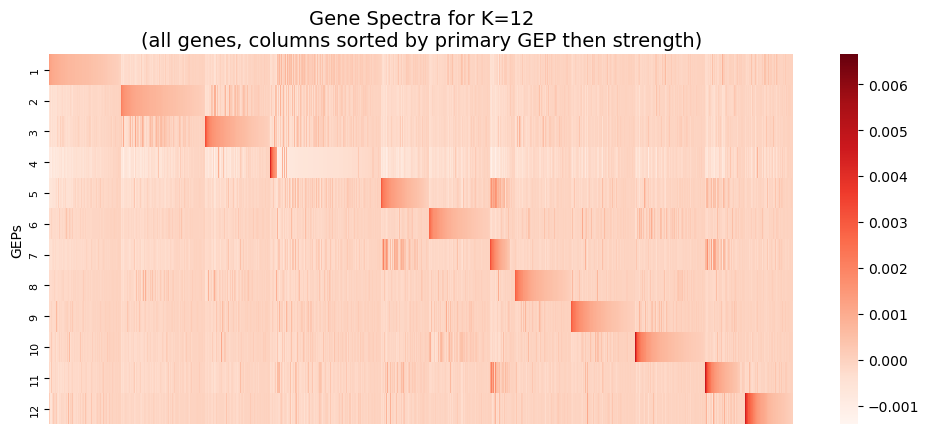

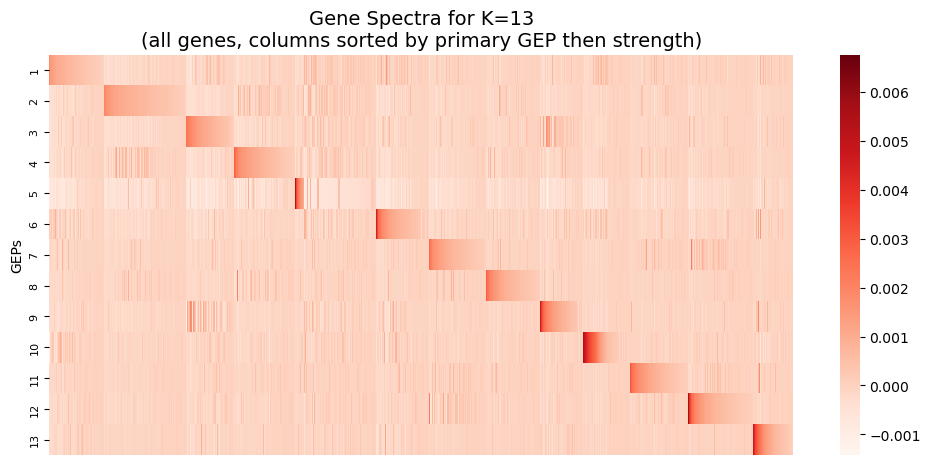

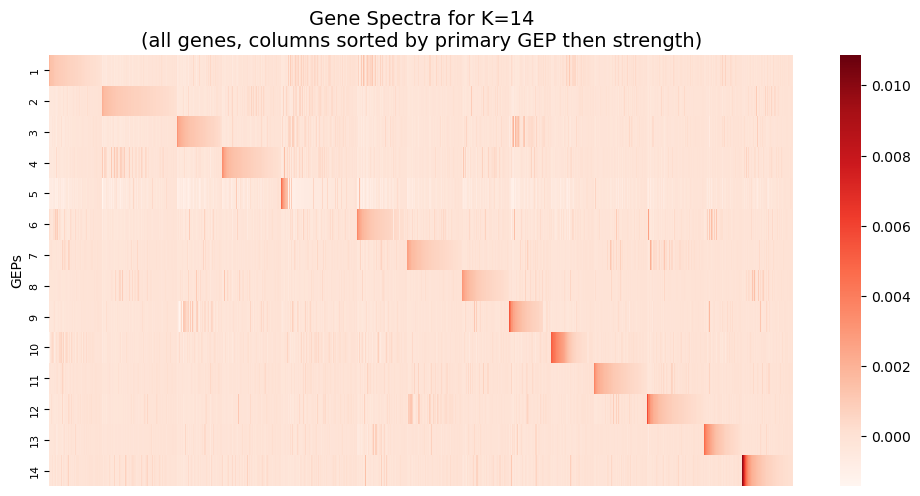

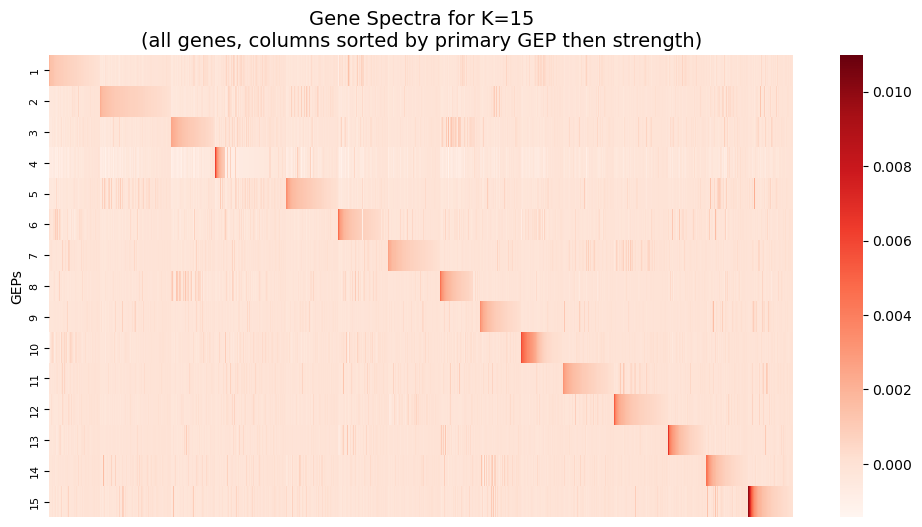

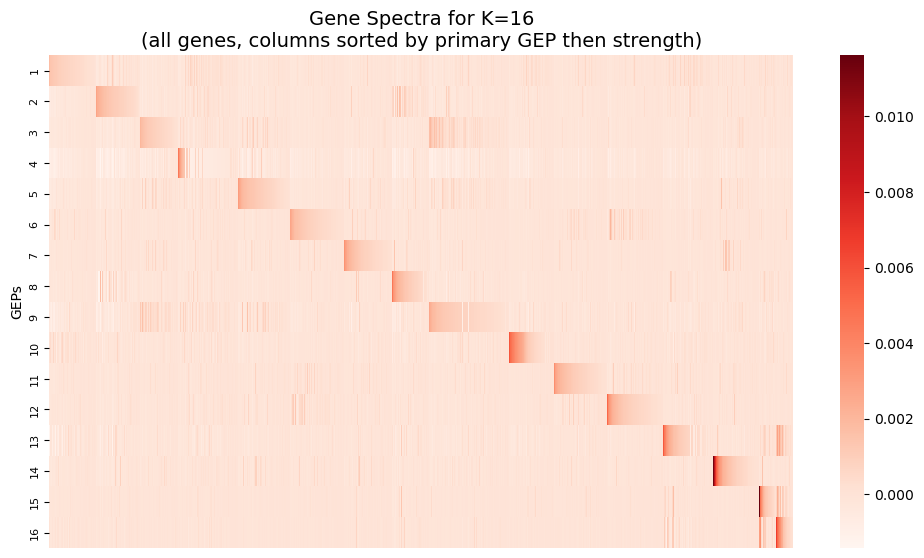

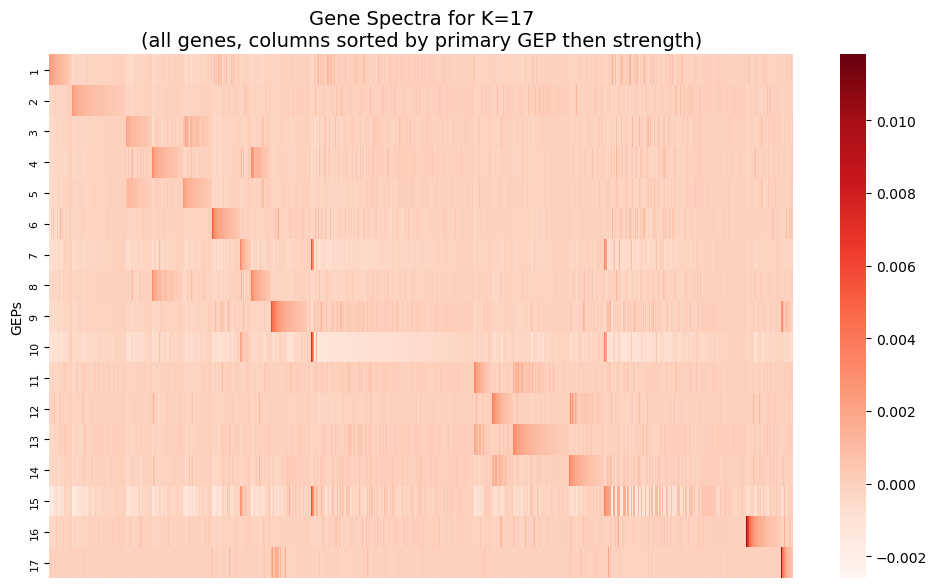

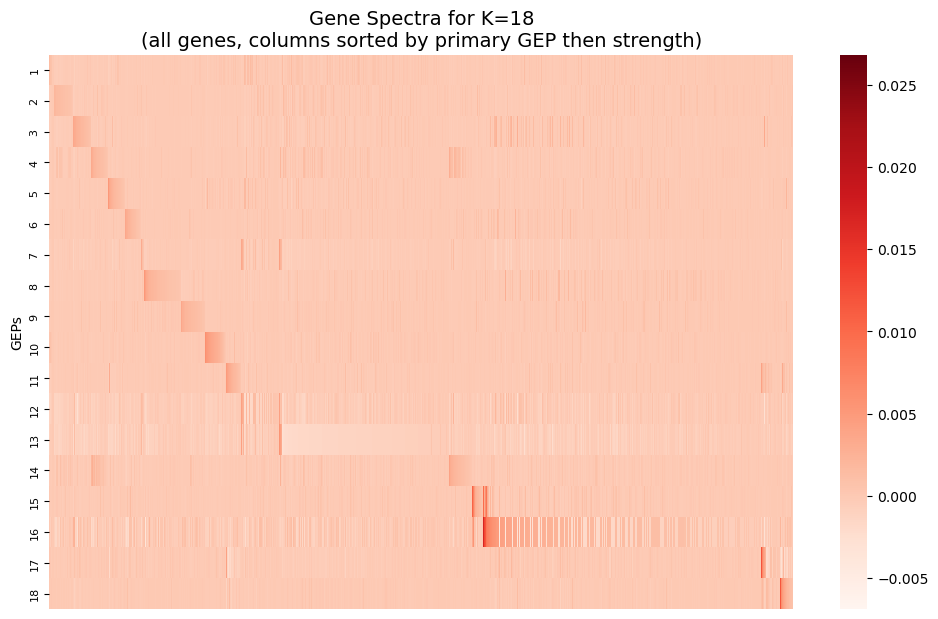

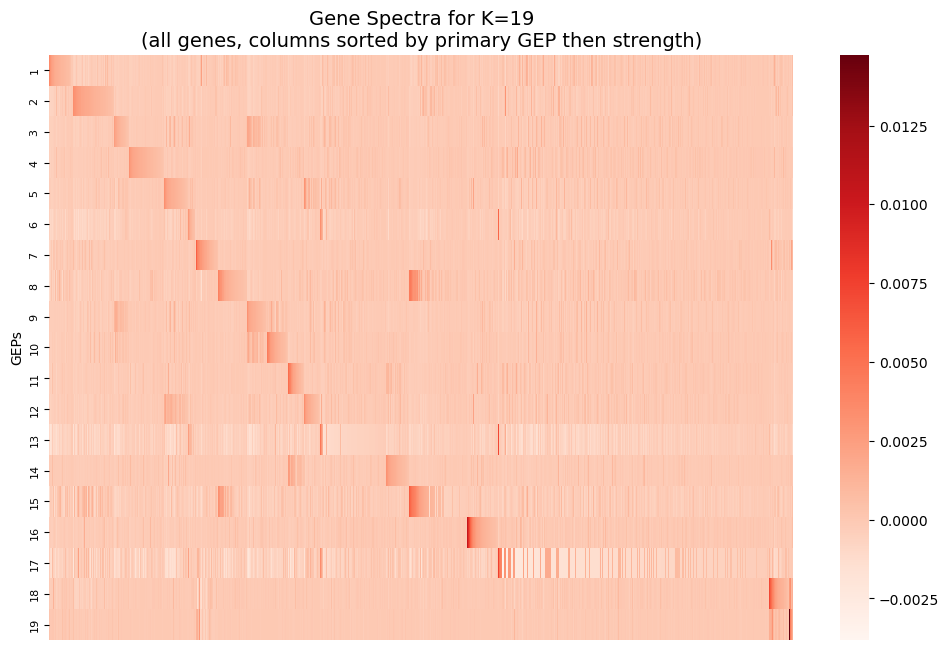

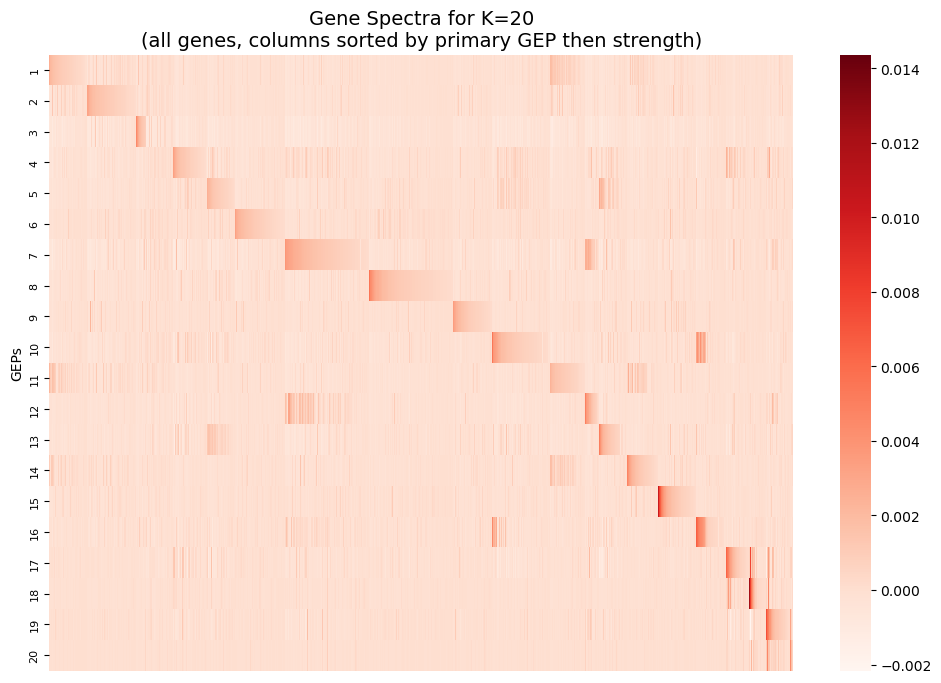

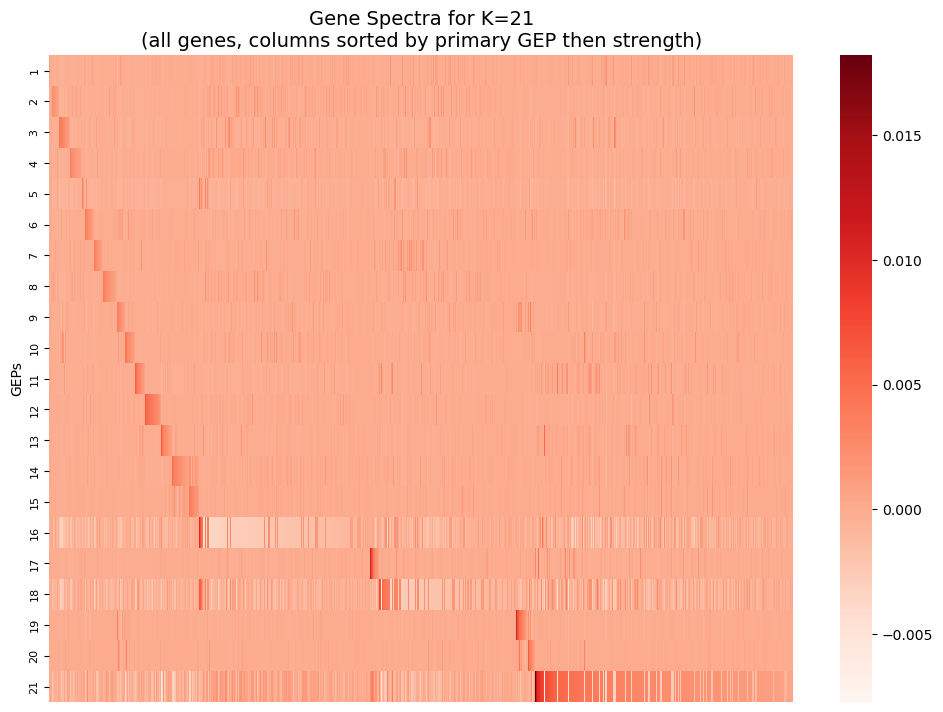

In [9]:
figs = plot_heatmaps_per_k(
    output_dir="all_datasets_consensus/anal_pc5_c21_S1.filtered_consensus_outputs",
    name="anal_pc5_c21_S1.filtered",
    save_dir="sorted_heatmaps",
)